<img src=images/Stöwer_Titanic.jpg align="right" width="15%" style="margin-right:10%">

#### August 18, 2016 - Women in Data Science ATX Meetup - "Data Science from Scratch" Workshop #6

# Hypothesis Testing on the Titanic Data Set with R

## 0. Preliminaries

### 0.1 Set up the R language kernel for Jupyter + load libraries
https://www.continuum.io/blog/developer/jupyter-and-conda-r

#### Assumption:
You have Anaconda installed. If not, go here for instructions:  
https://github.com/mGalarnyk/Installations_Mac_Ubuntu_Windows

#### Summary:
1. Open a shell and run this command to install `r-essentials` into the current environment:
<pre><code>conda install -c r r-essentials
</code></pre>
OR, run this command to install it into a new environment:
<pre><code>conda create -n my-r-env -c r r-essentials
</code></pre>
2. Start a new jupyter notebook session:
<pre><code>jupyter notebook</code></pre>

#### Note:
Beware that you may sometimes get traceback (error) messages that print one character per line, i.e., vertically. It looks like this bug has been fixed:  
https://github.com/IRkernel/IRkernel/issues/261

However, the date on the fix is later than the date of the latest release, IRkernel 0.6.1, so we'll just live with it for now:  
https://github.com/IRkernel/IRkernel/releases

In [34]:
# Load libraries
library(ggplot2) # visualization
library(dplyr)   # data manipulation
library(repr)    # used only to change default figure size

# Change figure size
options(repr.plot.width=6, repr.plot.height=4)

### 0.2 Resources
- *(DS From Scratch)* [Data Science From Scratch](http://shop.oreilly.com/product/0636920033400.do) - Chapter 7: Hypothesis and Inference
- *(OIS)* "OpenIntro Statistics" book: https://www.openintro.org/stat/textbook.php?stat_book=os - Chapter 4: Foundations for Inference
- *(PPA)* "Practical Predictive Analytics: Models and Methods" course: (https://www.coursera.org/learn/predictive-analytics/home/week/1) - Week 1: Practical Statistical Inference  
- *(Wikipedia)*: https://en.wikipedia.org/wiki/Statistical_hypothesis_testing

Some text taken directly from:
- *(IS)* "Inferential Statistics" course: https://www.coursera.org/learn/inferential-statistics-intro/

Some code taken directly from:
- https://choens.github.io/titanic-workshop/03-eda-and-hypothesis-testing.html
- https://rpubs.com/jeffrey6557/52266

The files `train.csv` and `test.csv` were downloaded from https://www.kaggle.com/c/titanic/data.

### 0.3 Overview
Our goal in this workshop is to work through a hypothesis test on the same Titanic dataset that we've worked with in previous workshops. The Titanic data comes to us already having been randomly sampled into two files `train.csv` and `test.csv`. However, the file `test.csv` is unlabeled, so we won't use it unless we want to look at distributions of variables over the entire set of passenger data. 

We will be considering a *sample* from the *population* of all Titanic passengers (not including crew members). There were approximately [1317 passengers](http://www.titanicfacts.net/titanic-passengers.html) on board the Titanic when it sank.

We'll follow a general set of steps for statistical hypothesis testing.

## 1. Set the hypotheses
"The first step is to state the relevant null and alternative hypotheses. This is important, as mis-stating the hypotheses will muddy the rest of the process." - *Wikipedia*

Here are some examples of general hypotheses:
- "This coin is fair."
- "Data scientists prefer Python to R."
- "People are more likely to navigate away from the page without ever reading the content if we pop up an irritating interstitial advertisement with a tiny, hard-to-find close button."

\- *DS From Scratch*

Next, express the hypothesis you want to investigate as:
- a **null hypothesis** $H_0$ that represents some default position, and
- an **alternative hypothesis** $H_A$ that we'll compare $H_0$ with.

Another way to think of this is that we want to compare an experimental group and a control group. Stated this way:
- the **null hypothesis** claims that there is no difference between the groups, and
- the **alternative hypothesis** claims that there is a statistically significant difference between the groups.

### *Example:* Consider `Age` variable of Titanic data set
We've heard that women and children were asked to get on the lifeboats first when the Titanic was sinking. So let's investigate the general hypothesis that children aboard the Titanic had a better chance of survival than adults. Did they?

To answer this we can do a hypothesis test comparing two proportions: the proportion of children who survived, $p_{\rm child}$, and the proportion of adults who survived, $p_{\rm adult}$. We can state the null and alternative hypotheses as:
- $H_0$: $p_{\rm child} - p_{\rm adult} = 0$ There is no significant difference in the proportion of children who survive and the proportion of adults who survive.
- $H_A$: $p_{\rm child} - p_{\rm adult} > 0$ There is a better chance of survival for children than adults.

$p_{\rm child}$ is our unknown population proportion of children who survived  
$p_{\rm adult}$ is our unknown population proportion of adults who survived

Our *parameter of interest* is the difference between the proportions of **all** Titanic child passengers and **all** Titanic adult passengers who survived: $p_{\rm child} - p_{\rm adult}$.

Our *point estimate* is the difference between the proportions of **sampled** Titanic child passengers and **sampled** Titanic adult passengers who survived: $\hat{p}_{\rm child} - \hat{p}_{\rm adult}$.

## 2. Check assumptions and conditions
"The second step is to consider the statistical assumptions being made about the sample in doing the test; for example, assumptions about the statistical independence or about the form of the distributions of the observations. This is equally important as invalid assumptions will mean that the results of the test are invalid." - *Wikipedia*

In hypothesis testing the "control" and "experimental" groups are typically defined through careful experimental design. This is not usually the case in data science applications, though. An exception is collecting click-through data in an A/B test that measures the effect of new ad placement on your website compared to the control group, or existing placement. - *PPA*

"Decide which test is appropriate, and state the relevant test statistic." - *Wikipedia*

Since we are testing for equality of proportions between 2 samples it would be appropriate to use the **$X^2$ (Chi-squared) test** as our *test statistic*. See here: http://www.stat.wmich.edu/s216/book/node115.html

#### Here are the conditions for inference for comparing two independent proportions:
1. *Independence:*
    - **within groups**: sampled observations must be independent within each group
        - random sample/assignment
        - if sampling without replacement, $n < 10$% of population
    - **between groups**: the two groups must be independent of each other (non-paired)
    
2. *Sample size/skew:* Each sample should meet the success-failure condition:
    $$n_{\rm child} p_{\rm child} \ge 10 \quad \textrm{and} \quad n_{\rm child} (1 - p_{\rm child}) \ge 10$$
    $$n_{\rm adult} p_{\rm adult} \ge 10 \quad \textrm{and} \quad n_{\rm adult} (1 - p_{\rm adult}) \ge 10$$
    
Note that for calculating the *confidence interval* we need to use the "p-hat" values corresponding to the observed sample proportions.

#### Now let's check these conditions for our sample:

1. Check *independence*: 
    - check **within groups**:
        - the sample should be random for both adults and children since we either take the data from `train.csv` and work with that, or randomly sample the data ourselves.
        - to meet the 10% condition we need to estimate how many children and how many adults are in the *population* of Titanic passengers.
      
        $\rightarrow$ Let's take a break to look at the Titanic data so we can check the 10% condition, then continue with the other cchecks.

#### Load the Titanic training data set:

In [35]:
train <- read.csv("data/train.csv")  # read in Titanic training data csv file to R data frame
str(train)                           # display data frame using R `str` function

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


The training data set is a random sample of 891 passengers from the total 1309 passengers in our data set. This is just over 67% of all 1317 passengers aboard the Titanic when it sank. 

We can already see that we probably won't meet the 10% condition since we have loaded data on over half the passengers. 

**Let's find how many children, $N_{\rm child}$, and how many adults, $N_{\rm adult}$, are in the entire data set (both `train.csv` and `test.csv` files) or *population*:**

In [38]:
# THE ENTIRE POPULATION
test  <- read.csv('data/test.csv')   # read in Titanic test data csv file

training <- data.frame(train$Age, train$Sex, train$Pclass)  # disclude Survived and assign to new data frame so we don't lose "train"
names(training) <- c("Age", "Sex","Pclass") # rename column variables
testing <- data.frame(test$Age, test$Sex, test$Pclass)
names(testing)  <- c("Age", "Sex","Pclass")

full  <- bind_rows(training, testing)      # bind training & test data
str(full)  # note that there are 1309 observations, which is over 99% of the entire population of 1317

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1309 obs. of  3 variables:
 $ Age   : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ Sex   : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Pclass: int  3 1 3 1 3 3 1 3 3 2 ...


#### First, check for missing values of `Age`:
We actually only have ages for 1046 passengers, which is about 79% of the total population of 1317 passengers.

In [39]:
full <- full[!is.na(full$Age),] # drop all rows with missing ages
str(full)

Classes ‘tbl_df’ and 'data.frame':	1046 obs. of  3 variables:
 $ Age   : num  22 38 26 35 35 54 2 27 14 4 ...
 $ Sex   : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 1 1 1 ...
 $ Pclass: int  3 1 3 1 3 1 3 3 2 3 ...


We'll proceed to estimate $N_{\rm child}$ and $N_{\rm adult}$ based on these 1046 passengers, then scale them up by a factor of 1317/1046, or $\approx 1.259$

#### But first let's take a look at the distribution of passenger ages:

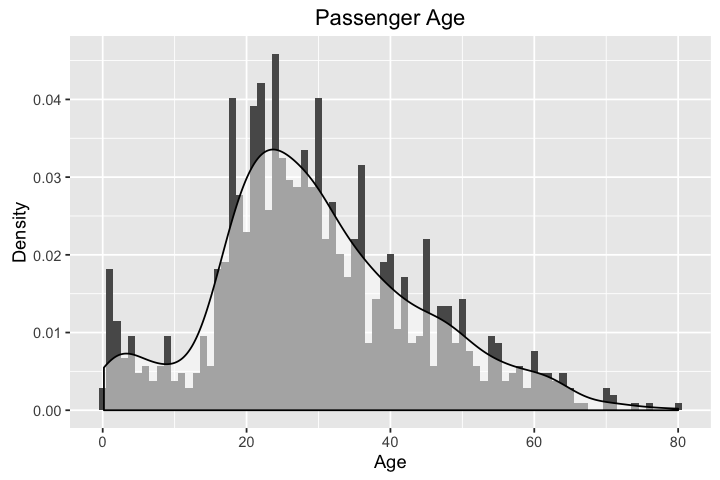

In [40]:
# Overlay a probability distribution function (PDF) on a histogram of Age
ggplot(full, aes(x=Age)) + 
    ggtitle("Passenger Age") + 
    xlab("Age") + 
    ylab("Density") + 
    geom_histogram(aes(y=..density..), binwidth=1)+
    geom_density(alpha=.5, fill="#FFFFFF")

In [49]:
min(full$Age) * 12 # convert from years to months
max(full$Age)

[1] 2.04

[1] 80

The youngest passenger in this sample was 2 months old and the oldest was 80 years old, which seems quite a bit older than the average life expectancy of early to mid 50s for the year 1912 when the Titanic sank: http://demog.berkeley.edu/~andrew/1918/figure2.html

Though the distribution of numerical ages is obviously not normally distributed, we can take a look at the discrepancies at extreme ages with a normal quantile plot. The data is noticeably right-skewed, although there is clear dip in the number of pre-teen and teenage passengers. 

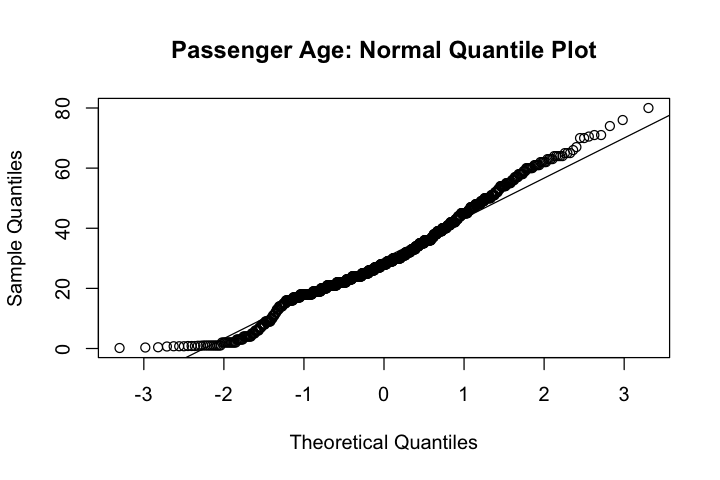

In [42]:
qqnorm(full$Age, main="Passenger Age: Normal Quantile Plot")
qqline(full$Age)

#### Now let's discretize the numerical `Age` column values into two groups:

In [50]:
# Add a new categorical variable called "AgeGroup" with values "Child" or "Adult".
full$AgeGroup <- "Adult"
full$AgeGroup[full$Age < 18] <- "Child"

In [63]:
table(full$AgeGroup)
table(full$AgeGroup) * 1.259 # scale up values so total is 1317


Adult Child 
  892   154 


   Adult    Child 
1123.028  193.886 

So we'll estimate $N_{\rm child} \approx 194$ and $N_{\rm adult} \approx 1123$. This means that our sample sizes should be $n_{\rm child} < 19$ and $n_{\rm adult} < 112$ to the 10% criterion for independence.

#### Subset, drop rows with missing `Age` values, then take a random *sample* from the `train` data frame of $\lesssim 10$%:

In [107]:
train <- data.frame(train$Survived, train$Age, train$Sex, train$Pclass); # select 4 columns of data frame
names(train) <- c("Survived", "Age", "Sex","Pclass"); # rename columns from, e.g., train$Survived to Survived

# Let's keep the data frame "train" intact for later use, and create a new one called "train_age"
train_age <- train[!is.na(train$Age),] # strip "train" data of rows with Age=NULL
summary(train_age$Age)                 # show some descriptive statistics of Age variable

mysample <- train_age[sample(1:nrow(train_age), 115, replace=FALSE),]
str(mysample)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.42   20.12   28.00   29.70   38.00   80.00 

'data.frame':	115 obs. of  4 variables:
 $ Survived: int  0 0 1 0 1 1 1 0 1 0 ...
 $ Age     : num  57 31 24 33 54 25 34 28 30 38 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 2 1 1 1 2 1 2 ...
 $ Pclass  : int  2 3 2 3 1 2 2 2 2 1 ...


#### Discretize the ages in `mysample` into two groups - adults and children - and check the condition:

In [108]:
length(which(mysample$Age < 18))
length(which(mysample$Age >= 18))

[1] 17

[1] 98

A sample size of $n = 115$ worked.

In [110]:
# Add a new categorical variable called "AgeGroup" with values "Child" or "Adult".
mysample$AgeGroup <- "Adult"
mysample$AgeGroup[mysample$Age < 18] <- "Child"

In [111]:
# Add a new categorical variable called "Lived" with "Yes" or "No" instead of "1" or "0" for Survival.
mysample$Lived[ mysample$Survived == 1 ] <- "Yes"
mysample$Lived[ mysample$Survived == 0 ] <- "No"

# Return a contingency table of the new Lived column.
lived <- table( mysample$Lived )
lived


 No Yes 
 72  43 

In [112]:
# Create a contingency table with proportions.
percent_lived <- round( 100*prop.table( lived ), 2 )
percent_lived


   No   Yes 
62.61 37.39 

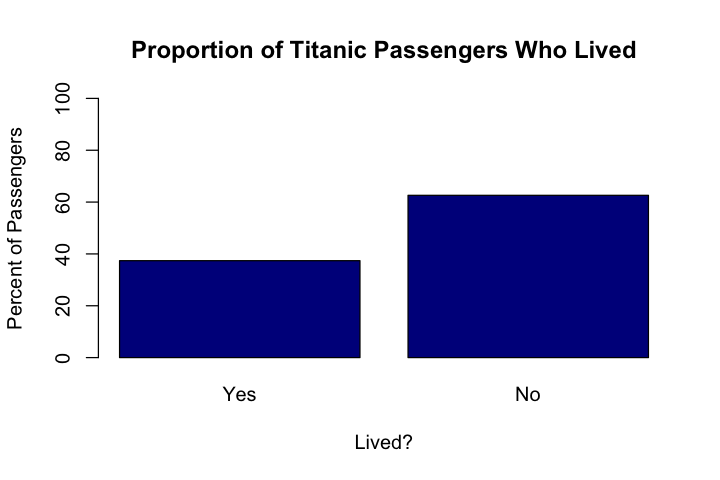

In [113]:
# Let's plot that for fun
barplot(sort(percent_lived, decreasing=FALSE),
        main="Proportion of Titanic Passengers Who Lived",
        xlab="Lived?", 
        ylab="Percent of Passengers",
        col="darkblue",
        ylim=c(0,100)
        )

#### Make frequency and proportion tables of child/adult survival:

In [114]:
# `table` creates a contingency table
age_group_lived <- table(mysample$AgeGroup, mysample$Lived)
age_group_lived

       
        No Yes
  Adult 63  35
  Child  9   8

In [91]:
# `prop.table` gives the row percentages
age_group_lived_prop <- prop.table(age_group_lived, margin=1) # 1 = rows, 2 = columns
age_group_lived_prop

       
          No  Yes
  Adult 0.64 0.36
  Child 0.60 0.40

"2." *Sample size/skew:* Each sample should meet the success-failure condition:
    $$n_{\rm child} p_{\rm child} \ge 10 \quad \textrm{and} \quad n_{\rm child} (1 - p_{\rm child}) \ge 10$$
    $$n_{\rm adult} p_{\rm adult} \ge 10 \quad \textrm{and} \quad n_{\rm adult} (1 - p_{\rm adult}) \ge 10$$

In [123]:
(age_group_lived[3] + age_group_lived[4]) * age_group_lived_prop[4]
(age_group_lived[3] + age_group_lived[4]) * (1 - age_group_lived_prop[4])

(age_group_lived[1] + age_group_lived[2]) * age_group_lived_prop[2]
(age_group_lived[1] + age_group_lived[2]) * (1 - age_group_lived_prop[2])

[1] 17.2

[1] 25.8

[1] 43.2

[1] 28.8

## 3. Calculate a *test statistic* and a $p$-value (draw a picture!)

"Compute from the observations the observed value of the test statistic." - *Wikipedia*

"Calculate the $p$-value. This is the probability, under the null hypothesis, of sampling a test statistic at least as extreme as that which was observed." - *Wikipedia*

In [132]:
# chi-squared test between Survived, Age
chisq.test(mysample$Survived, mysample$AgeGroup)


	Pearson's Chi-squared test with Yates' continuity correction

data:  mysample$Survived and mysample$AgeGroup
X-squared = 0.38554, df = 1, p-value = 0.5347


In [134]:
# chi-squared test between Survived, Age for whole `train` dataframe
chisq.test(train$Survived, train$AgeGroup)

Warning message:
In chisq.test(train$Survived, train$AgeGroup): Chi-squared approximation may be incorrect


	Chi-squared test for given probabilities

data:  train$Survived
X-squared = 549, df = 890, p-value = 1


In [136]:
# another method of chi-squared test
summary(table(mysample$Survived, mysample$AgeGroup))

Number of cases in table: 115 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 0.7964, df = 1, p-value = 0.3722

## 4. Make a decision, and interpret it in the context of the research question
"Reject the null hypothesis, in favor of the alternative hypothesis, if and only if the `p`-value is less than the significance level (the selected probability) threshold." - *Wikipedia*

- If $p$-value $< \alpha$, reject $H_0$, data provide evidence for $H_A$
- If $p$-value $> \alpha$, do not reject $H_0$, data do not provide evidence for $H_A$

A near-zero p-value indicates that the evidence supports the alternative hypothesis that children are more likely to have survived. However, we have a p-value of 0.53.

So, we **do not reject the null hypothesis**.

There's a 53% chance you'd observe such an extreme statistic if our null hypothesis were true.

|                    | Do Not Reject $H_0$                   | Reject $H_0$                         |
|--------------------|:-------------------------------------:|:------------------------------------:|
| **$H_0$ is True**  | *Correct Decision*<br>($1 - \alpha$)  | *Type 1 Error*<br>($\alpha$)         |
| **$H_0$ is False** | *Type 2 Error*<br> ($\beta)$          | *Correct Decision*<br> ($1 - \beta)$ |

### *Example:* Consider `Sex` variable

In [141]:
chisq.test(mysample$Survived, mysample$Sex)


	Pearson's Chi-squared test with Yates' continuity correction

data:  mysample$Survived and mysample$Sex
X-squared = 35.606, df = 1, p-value = 2.415e-09


A near-zero p-value indicates that the evidence supports the alternative hypothesis that children are more likely to have survived.

So, we **reject the null hypothesis**.

There's a (basically) 0% chance you'd observe such an extreme statistic if our null hypothesis were true.

## EXERCISE TIME!
Now try working through hypothesis testing on `Pclass` or `Sex`!

### *Exercise:*  Sampling distribution of point estimates for the example problem
Take a bunch of random samples of size $n = 110$, calculate the point estimates, $\hat{p}_{\rm child} - \hat{p}_{\rm adult}$, then plot the sampling distribution. You can copy the code from the hist/pdf and qqplot we plotted for Age. Check for normality.

### *Exercise:* Try using a permutation test for the example problem
- https://rpubs.com/jeffrey6557/52266
- https://en.wikipedia.org/wiki/Resampling_(statistics)
- http://thomasleeper.com/Rcourse/Tutorials/permutationtests.html


### *Exercise:* Consider `Pclass` (passenger class) variable
Next we could look at whether upper class passengers aboard the Titanic had a better chance of survival than lower class passengers. We would compare the proportion of upper class passengers who survived, $p_{\rm upper}$, with the proportion of lower class passengers, $p_{\rm lower}$.
- $H_0$: $p_{\rm upper} - p_{\rm lower} = 0$ There is no significant difference in the chances of survival of upper and lower class passengers.
- $H_A$: $p_{\rm upper} - p_{\rm lower} > 0$ There is a better chance of survival for upper class passengers. 

If you need ideas, check this blog post:
https://www.analyticsvidhya.com/blog/2015/10/inferential-descriptive-statistics-beginners-r/

## Final Comments


"To do good *science*:"
>- Determine your hypotheses before looking at the data.
>- Clean your data without the hypotheses in mind.
>- Keep in mind that $p$-values are not substitutes for common sense.

- *DS From Scratch*

## More Resources
- http://gchang.people.ysu.edu/class/s5817/L/ReviewNote_5817.pdf
- https://www.encyclopedia-titanica.org/
- https://en.wikipedia.org/wiki/Resampling_(statistics)
- https://lagunita.stanford.edu/courses/HumanitiesScience/StatLearning - Chapter 5: Resampling Methods
- http://www.nature.com/news/scientific-method-statistical-errors-1.14700
- https://ds8.gitbooks.io/textbook/content/chapter5/intro.html
- [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) - PyCon 2016 talk by Jake Vanderplas
- https://www.analyticsvidhya.com/blog/2015/10/inferential-descriptive-statistics-beginners-r/

The notebook `2016-08-18-TitanicHypothesisTesting-python.ipynb` in this repository is the start of a translation from `R` to `Python` of the current notebook. If you'd like to help complete the translation, please fork the repository, make your changes, and issue a pull request!

Thanks for coming!!